In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import dimod.generators as dg
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from collections import OrderedDict

In [2]:
def to_base_ten(b_list):
    result = 0
    for i in range(len(b_list)):
        result += b_list[i] * 2**i
    return result

def extract_ab(sample, num_bits1, num_bits2):
    a = b = 0
    for i in range(num_bits1):
        a += sample["a" + str(i)] * 2**i
    for i in range(num_bits2):
        b += sample["b" + str(i)] * 2**i
    return a, b

In [81]:
P = 21
num_bits1 = 5
num_bits2 = 5
bqm = dg.multiplication_circuit(num_bits1, num_bits2)
print("BQM has {} variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

p_vars = [var for var in list(bqm.variables) if "p" in var]
print(p_vars)
#p_vars = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']

# Convert P from decimal to binary
#fixed_variables = dict(zip(reversed(p_vars), "{:06b}".format(P)))
#fixed_variables = {var: int(x) for(var, x) in fixed_variables.items()}
fixed_variables = np.zeros(len(p_vars))
for i in range(len(p_vars)):
    fixed_variables[i] = math.floor(P / 2**i ) % 2

# Fix product variables
for i in range(len(p_vars)):
    bqm.fix_variable(p_vars[i], fixed_variables[i])
    
print("BQM has {} non-fixed variables: \n\t{}".format(len(bqm.variables), list(bqm.variables)))

BQM has 75 variables: 
	['a0', 'b0', 'p0', 'b1', 'and0,1', 'b2', 'and0,2', 'b3', 'and0,3', 'b4', 'and0,4', 'a1', 'and1,0', 'p1', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'sum1,2', 'carry1,2', 'and1,3', 'sum1,3', 'carry1,3', 'and1,4', 'sum1,4', 'carry1,4', 'a2', 'and2,0', 'p2', 'carry2,0', 'and2,1', 'sum2,1', 'carry2,1', 'and2,2', 'sum2,2', 'carry2,2', 'and2,3', 'sum2,3', 'carry2,3', 'and2,4', 'sum2,4', 'carry2,4', 'a3', 'and3,0', 'p3', 'carry3,0', 'and3,1', 'sum3,1', 'carry3,1', 'and3,2', 'sum3,2', 'carry3,2', 'and3,3', 'sum3,3', 'carry3,3', 'and3,4', 'sum3,4', 'carry3,4', 'a4', 'and4,0', 'p4', 'carry4,0', 'and4,1', 'p5', 'carry4,1', 'and4,2', 'p6', 'carry4,2', 'and4,3', 'p7', 'carry4,3', 'and4,4', 'p8', 'p9']
['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
BQM has 65 non-fixed variables: 
	['a0', 'b0', 'b1', 'and0,1', 'b2', 'and0,2', 'b3', 'and0,3', 'b4', 'and0,4', 'a1', 'and1,0', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'sum1,2', 'carry1,2', 'an

In [82]:
sampler = DWaveSampler()
print("QPU {} was selected.".format(sampler.solver.name))
embedding_sampler = EmbeddingComposite(sampler)
sampleset = embedding_sampler.sample(bqm, num_reads=1000, label="Factorization", annealing_time=500)

QPU Advantage_system4.1 was selected.


First 5 solutions for ab = 21:
(1, 5)
(21, 1)
(7, 3)
(3, 23)
(11, 3)
{'timing': {'qpu_sampling_time': 644200.0, 'qpu_anneal_time_per_sample': 500.0, 'qpu_readout_time_per_sample': 123.66, 'qpu_access_time': 659960.37, 'qpu_access_overhead_time': 2029.63, 'qpu_programming_time': 15760.37, 'qpu_delay_time_per_sample': 20.54, 'post_processing_overhead_time': 5306.0, 'total_post_processing_time': 5306.0}, 'problem_id': 'ca17f970-f55c-490f-be61-2c11a5c65b7b', 'problem_label': 'Factorization'}


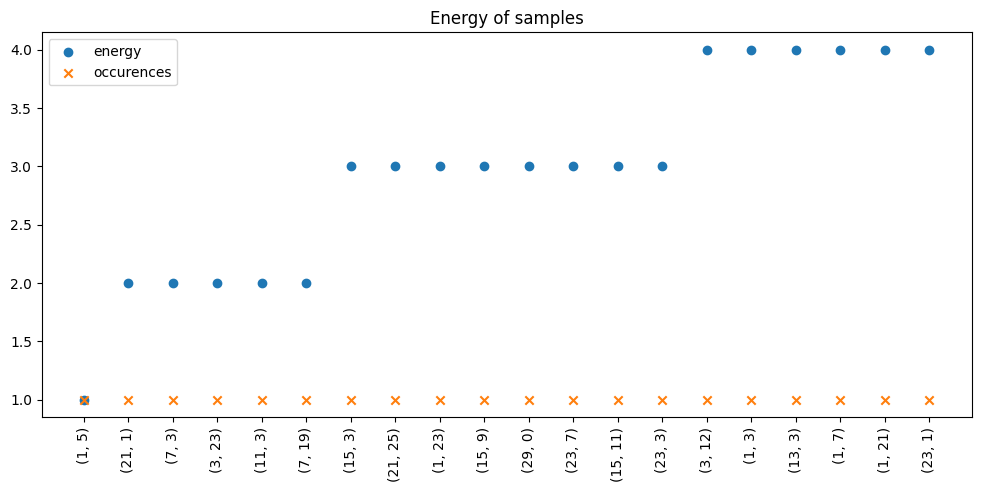

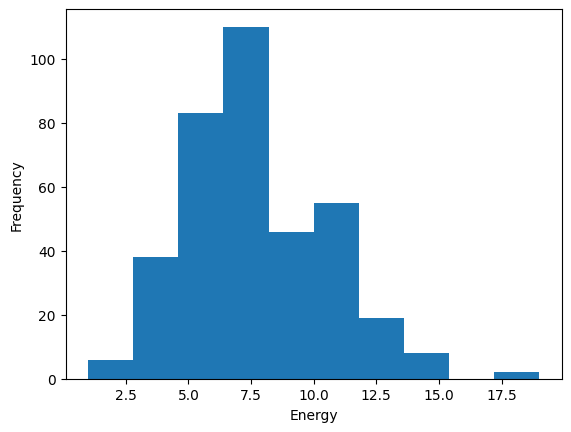

In [83]:
sample = sampleset.first.sample

def response_to_dict(sampleset):
    results_dict = OrderedDict()

    for sample, energy, num in sampleset.data(['sample', 'energy', 'num_occurrences']):
        a, b = extract_ab(sample, num_bits1, num_bits2)
        if (a, b) not in results_dict:
            results_dict[(a, b)] = [round(energy, 2), num]
    return results_dict

def energy_of(results):
    x_range = [str(x) for x in results.keys()]

    plt.figure(figsize=(12, 5))
    ax = plt.gca()
    ax.set_title("Energy of samples")
    values = np.array(list(results.values()))
    #Plot the lowest few energy solutions
    ax.scatter(x_range[:20], values[:20,0], label='energy')
    ax.scatter(x_range[:20], values[:20,1], label='occurences', marker='x')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(values[:,0], weights=values[:,1])
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.show()

results = response_to_dict(sampleset)
print("First 5 solutions for ab = {}:".format(P))
for i in range(5):
    print(list(results.keys())[i])

print(sampleset.info)
energy_of(results)